# Metrics across sample numbers

In [1]:
import pandas as pd
from baseline.eval import cal_group_kl_divergence

eval_list = []
for i in range(11):
    num_samples = i*100
    result_file = f"models/mobility_agent/mobility_agent_{num_samples}.csv"
    result_df = pd.read_csv(result_file)
    kl_df, overall_kl,overall_mae = cal_group_kl_divergence(result_df=result_df)
    for target in ["primary_mode","duration_minutes"]:
        kld_score = kl_df[kl_df["target"] == target]['kl_divergence'].mean()
        mea_score = kl_df[kl_df["target"] == target]['mae'].mean()
        eval_list.append({
            "model":"mobility_agent",
            "num_samples":num_samples,
            "target":target,
            "kld_score": kld_score,
            "mea_score":mea_score
        })

eval_df = pd.DataFrame(eval_list)
eval_df.head(2)


,model,num_samples,target,kld_score,mea_score
0,mobility_agent,0,primary_mode,1.175448,0.141829
1,mobility_agent,0,duration_minutes,1.552403,0.189916


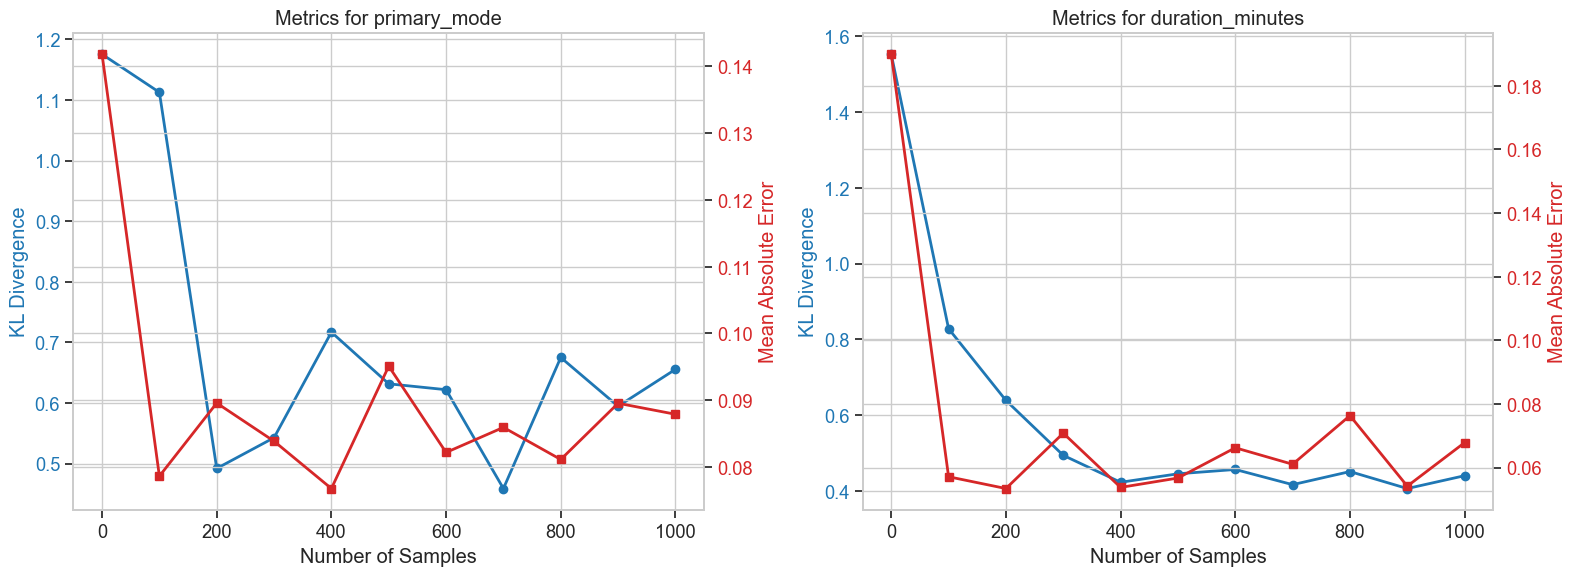

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create subplots for each target
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, target in enumerate(eval_df['target'].unique()):
    target_df = eval_df[eval_df['target'] == target]
    
    # Create primary y-axis
    ax1 = axes[i]
    color = 'tab:blue'
    ax1.set_xlabel('Number of Samples')
    ax1.set_ylabel('KL Divergence', color=color)
    ax1.plot(target_df['num_samples'], target_df['kld_score'], 
             marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create secondary y-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean Absolute Error', color=color)
    ax2.plot(target_df['num_samples'], target_df['mea_score'], 
             marker='s', color=color, linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax1.set_title(f'Metrics for {target}')
    ax1.grid(True)

plt.tight_layout()
plt.show()

In [1]:
from baseline.multilayer_perceptron import MultilayerPerceptron
import random
import numpy as np
import pandas as pd
import os

# 设置全局随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)  # 确保哈希随机性也被控制

train_file = "data/reference/replica-cambridge_trips.csv"
eval_file = 'data/eval/replica-cambridge_trips_eval.csv'
for i in range(1,11):
    num_samples = i*100
    model = MultilayerPerceptron(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed)
    model.train(optimize_first=False)
    kl_df,overall_kl,overall_mae = model.evaluate()

=======Training model (num_samples=100)=======
Model saved to models/multilayer_perceptron/multilayerperceptron_100.joblib
=======Evaluating model=======
Overall average KL divergence: 0.7164
Overall mean absolute error: 0.0623
=======Training model (num_samples=200)=======
Model saved to models/multilayer_perceptron/multilayerperceptron_200.joblib
=======Evaluating model=======
Overall average KL divergence: 0.5756
Overall mean absolute error: 0.0516
=======Training model (num_samples=300)=======
Model saved to models/multilayer_perceptron/multilayerperceptron_300.joblib
=======Evaluating model=======
Overall average KL divergence: 0.6821
Overall mean absolute error: 0.0500
=======Training model (num_samples=400)=======
Model saved to models/multilayer_perceptron/multilayerperceptron_400.joblib
=======Evaluating model=======
Overall average KL divergence: 0.5200
Overall mean absolute error: 0.0495
=======Training model (num_samples=500)=======
Model saved to models/multilayer_perceptr

# Mobility Agent vs ML models

In [ ]:
from baseline.random_forest import RandomForest
from baseline.xgboost import XGBoost
from baseline.multilayer_perceptron import MultilayerPerceptron
from baseline.eval import cal_group_kl_divergence

import random
import numpy as np
import pandas as pd
import os
# 设置全局随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)  # 确保哈希随机性也被控制

train_file = "data/reference/replica-cambridge_trips.csv"
eval_file = 'data/eval/replica-cambridge_trips_eval.csv'
num_samples = 1000

ML_models = {
    "RF": RandomForest(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed),
    "XGB": XGBoost(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed),
    "MLP": MultilayerPerceptron(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed)
}

eval_list = []

for key,model in ML_models.items():
    model.train()
    kl_df,overall_kl,overall_mae = model.evaluate()
    for target in ["primary_mode","duration_minutes"]:
        kld_score = kl_df[kl_df["target"] == target]['kl_divergence'].mean()
        mea_score = kl_df[kl_df["target"] == target]['mae'].mean()
        eval_list.append({
            "model":key,
            "num_samples":num_samples,
            "target":target,
            "kld_score": kld_score,
            "mea_score":mea_score
        })


result_file = f"models/mobility_agent/mobility_agent_{num_samples}.csv"
result_df = pd.read_csv(result_file)
kl_df, overall_kl,overall_mae = cal_group_kl_divergence(result_df=result_df) 
for target in ["primary_mode","duration_minutes"]:
    kld_score = kl_df[kl_df["target"] == target]['kl_divergence'].mean()
    mea_score = kl_df[kl_df["target"] == target]['mae'].mean()
    eval_list.append({
        "model":"MA(qwen3:8b)",
        "num_samples":num_samples,
        "target":target,
        "kld_score": kld_score,
        "mea_score":mea_score
    })

========Optimizing parameters========
Best parameters: {'estimator__max_depth': 20, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 10}
Best cross-validation score: -0.5646
=======Training model (num_samples=1000)=======
Model saved to models/random_forest/randomforest_1000.joblib
=======Evaluating model=======
Overall average KL divergence: 0.7223
Overall mean absolute error: 0.0628
========Optimizing parameters========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 0.001, 'estimator__max_depth': 20, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Best cross-validation score: -1.1335
=======Training model (num_samples=1000)=======
Model saved to models/xgboost/xgboost_1000.joblib
=======Evaluating model=======
Overall average KL divergence: 1.7448
Overall mean absolute error: 0.0972
========Optimizing parameters========
Best parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 1e-05, 'estim

In [ ]:
import pandas as pd
from baseline.eval import cal_group_kl_divergence
from baseline.random_forest import RandomForest
from baseline.xgboost import XGBoost
from baseline.multilayer_perceptron import MultilayerPerceptron
from baseline.eval import cal_group_kl_divergence

import random
import numpy as np
import pandas as pd
import os
# 设置全局随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)  # 确保哈希随机性也被控制

train_file = "data/reference/replica-cambridge_trips.csv"
eval_file = 'data/eval/replica-cambridge_trips_eval.csv'

eval_list = []
for i in range(11):
    num_samples = i*100
    result_file = f"models/mobility_agent/mobility_agent_{num_samples}.csv"
    result_df = pd.read_csv(result_file)
    kl_df, overall_kl,overall_mae = cal_group_kl_divergence(result_df=result_df)
    eval_list.append({
        "model":"mobility_agent",
        "num_samples":num_samples,
        "overall_kl":overall_kl,
        "overall_mae":overall_mae
    })
    if i>0 :
        ML_models = {
            "RF": RandomForest(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed),
            "XGB": XGBoost(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed),
            "MLP": MultilayerPerceptron(train_file=train_file,eval_file=eval_file,sample_num=num_samples,seed=seed)
        }
        for key,model in ML_models.items():
            model.train()
            kl_df,overall_kl,overall_mae = model.evaluate()
            eval_list.append({
            "model":key,
            "num_samples":num_samples,
            "overall_kl":overall_kl,
            "overall_mae":overall_mae
            })

========Optimizing parameters========
Best parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Best cross-validation score: -13.5417
=======Training model (num_samples=0)=======
Model saved to models/random_forest/randomforest_0.joblib
=======Evaluating model=======
Overall average KL divergence: 1.2607
Overall mean absolute error: 0.1308
========Optimizing parameters========
Best parameters: {'estimator__gamma': 0.1, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 10, 'estimator__subsample': 0.9}
Best cross-validation score: -12.2593
=======Training model (num_samples=0)=======
Model saved to models/xgboost/xgboost_0.joblib
=======Evaluating model=======
Overall average KL divergence: 3.6296
Overall mean absolute error: 0.1434
========Optimizing parameters========
Best parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator

,model,num_samples,overall_kl,overall_mae
0,mobility_agent,0,1.363925,0.165873
1,RF,0,1.260684,0.165873
2,XGB,0,3.629643,0.165873
3,MLP,0,1.492959,0.165873
4,mobility_agent,100,0.970524,0.067883
5,RF,100,1.816233,0.067883
6,XGB,100,2.811518,0.067883
7,MLP,100,0.613769,0.067883
8,mobility_agent,200,0.565676,0.071508
9,RF,200,1.018737,0.071508


In [ ]:
eval_df = pd.DataFrame(eval_list)
eval_df.head(2)
eval_df.to_csv("models/scores.csv")

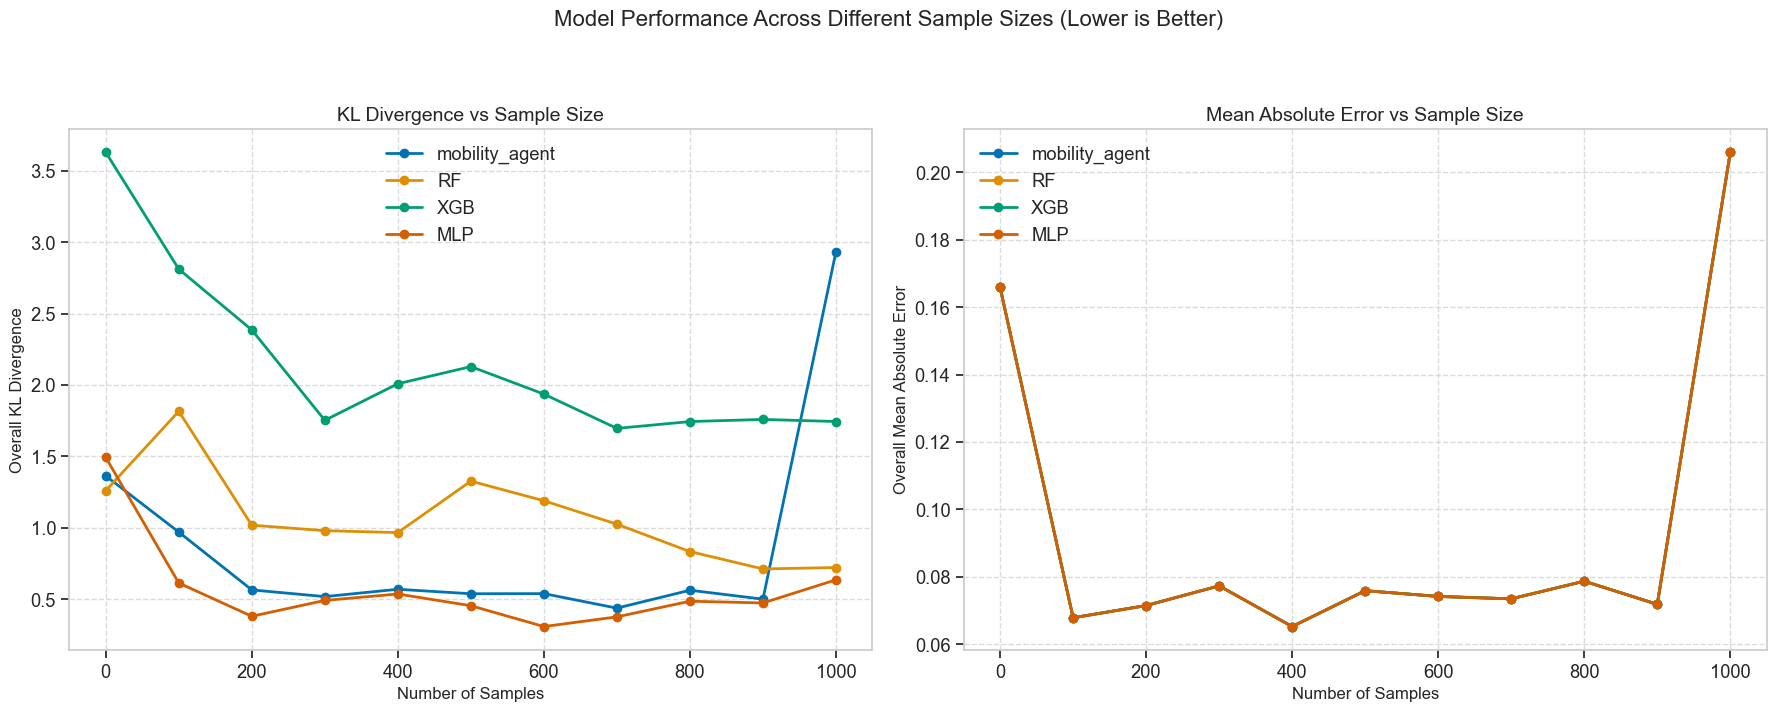

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Get unique models and create a color palette
models = eval_df['model'].unique()
palette = sns.color_palette("colorblind", len(models))
model_color = dict(zip(models, palette))

# Plot overall_kl in the first subplot
ax = axes[0]
for model in models:
    model_data = eval_df[eval_df['model'] == model].sort_values('num_samples')
    ax.plot(model_data['num_samples'], model_data['overall_kl'], 
            marker='o', linewidth=2, label=model, color=model_color[model])

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Overall KL Divergence', fontsize=12)
ax.set_title('KL Divergence vs Sample Size', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Plot overall_mae in the second subplot
ax = axes[1]
for model in models:
    model_data = eval_df[eval_df['model'] == model].sort_values('num_samples')
    ax.plot(model_data['num_samples'], model_data['overall_mae'], 
            marker='o', linewidth=2, label=model, color=model_color[model])

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Overall Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error vs Sample Size', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and add title
plt.tight_layout()
plt.suptitle('Model Performance Across Different Sample Sizes (Lower is Better)', 
            fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()

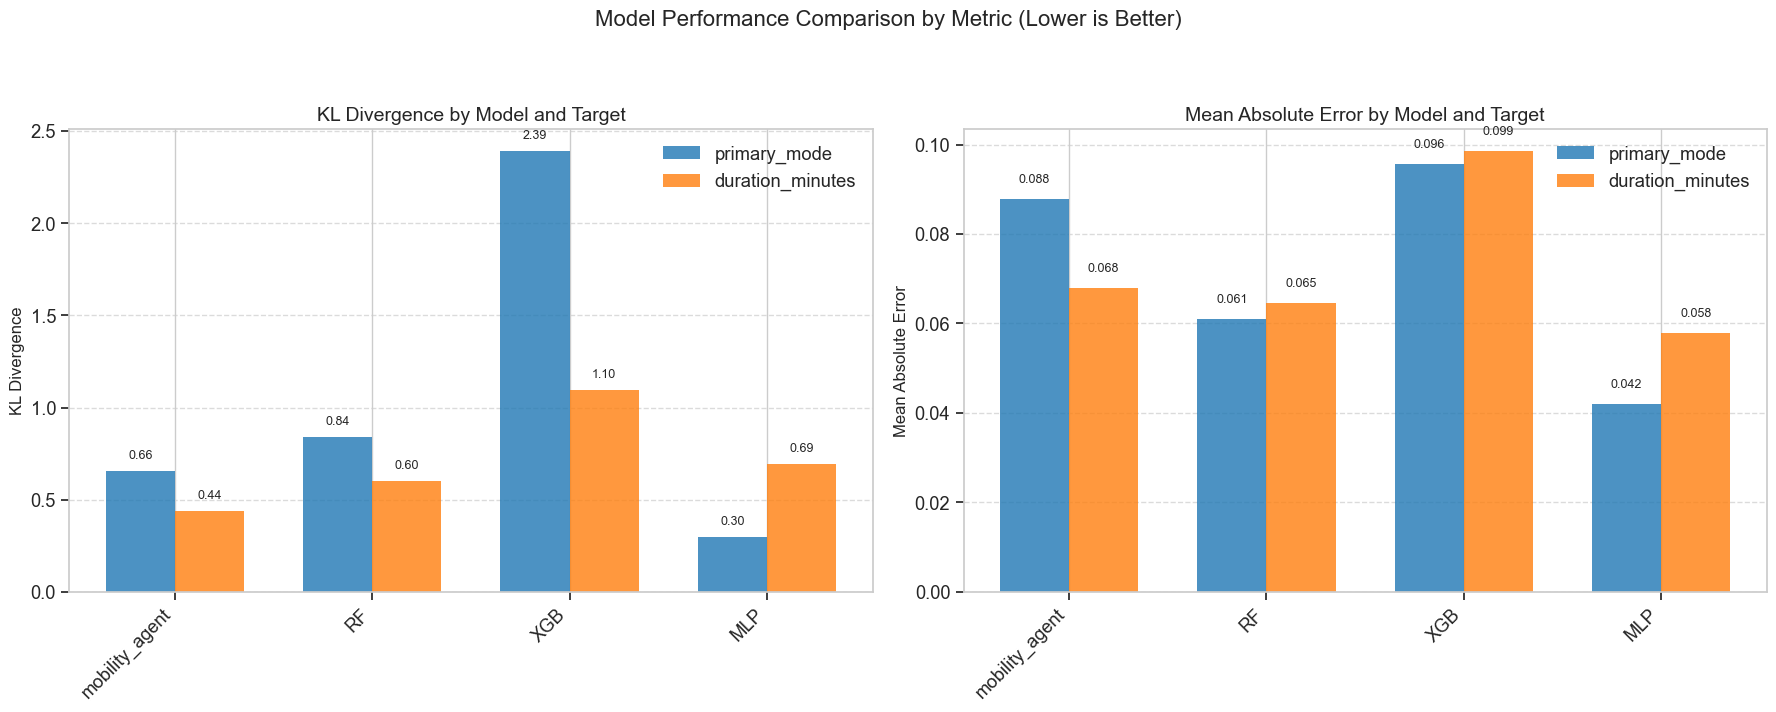

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Get unique models and ensure consistent ordering
model_order = ['mobility_agent', 'RF', 'XGB', 'MLP']  # Define explicit order
models = [m for m in model_order if m in eval_df['model'].unique()]  # Filter to existing models
targets = eval_df['target'].unique()

# Define colors for targets
target_colors = {'primary_mode': '#1f77b4', 'duration_minutes': '#ff7f0e'}

# Set width of bars and positions
bar_width = 0.35
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Data preparation - use model_order for consistent ordering
primary_data = []
duration_data = []
for model in models:
    primary_row = eval_df[(eval_df['model'] == model) & (eval_df['target'] == 'primary_mode')]
    duration_row = eval_df[(eval_df['model'] == model) & (eval_df['target'] == 'duration_minutes')]
    
    if not primary_row.empty:
        primary_data.append(primary_row.iloc[0])
    if not duration_row.empty:
        duration_data.append(duration_row.iloc[0])

primary_df = pd.DataFrame(primary_data)
duration_df = pd.DataFrame(duration_data)

# KLD subplot
ax = axes[0]
bars1 = ax.bar(r1, primary_df['kld_score'], width=bar_width, label='primary_mode', 
              color=target_colors['primary_mode'], alpha=0.8)
bars2 = ax.bar(r2, duration_df['kld_score'], width=bar_width, label='duration_minutes', 
              color=target_colors['duration_minutes'], alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
               f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Set labels and titles
ax.set_ylabel('KL Divergence', fontsize=12)
ax.set_title('KL Divergence by Model and Target', fontsize=14)
ax.set_xticks([r + bar_width/2 for r in range(len(models))])
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# MAE subplot
ax = axes[1]
bars1 = ax.bar(r1, primary_df['mea_score'], width=bar_width, label='primary_mode', 
              color=target_colors['primary_mode'], alpha=0.8)
bars2 = ax.bar(r2, duration_df['mea_score'], width=bar_width, label='duration_minutes', 
              color=target_colors['duration_minutes'], alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Set labels and titles
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Model and Target', fontsize=14)
ax.set_xticks([r + bar_width/2 for r in range(len(models))])
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.suptitle('Model Performance Comparison by Metric (Lower is Better)', 
            fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)
plt.show()